In [1]:
from PIL import Image
from os import path, listdir
import numpy as np
from random import sample
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm

Matplotlib created a temporary config/cache directory at /tmp/matplotlib-h3tigrud because the default path (/.config/matplotlib) is not a writable directory; it is highly recommended to set the MPLCONFIGDIR environment variable to a writable directory, in particular to speed up the import of Matplotlib and to better support multiprocessing.


In [2]:
import tensorflow as tf
from tensorflow.keras.layers import Activation, Conv2D, Conv2DTranspose, Dense, MaxPool2D, LeakyReLU, \
BatchNormalization, Dropout, Reshape, Flatten, RepeatVector, Add, ReLU, GlobalAveragePooling2D, AveragePooling2D, \
UpSampling2D, Layer
from tensorflow.keras import Model, Input, Sequential
from tensorflow.keras.optimizers import Adam, RMSprop
from tensorflow.keras.constraints import  max_norm
from tensorflow.keras.initializers import RandomNormal
from tensorflow.keras import backend

In [3]:
FOLDER = 'train'
PROGRESS_FOLDER = 'progress'
LATENT_FEATURES_SIZE = 98
IN_DIM = 4
INITIAL_SHAPE = (IN_DIM, IN_DIM, 3)
TRAIN = list(map(lambda x: path.join(FOLDER, x), listdir(FOLDER)))

In [4]:
class PixelNorm(Layer):
    def __init__(self, **kwargs):
        super(PixelNorm, self).__init__(**kwargs)
        
        
    def call(self, data):
        squared = data**2
        mean = backend.mean(squared, axis=-1, keepdims=True)
        norm = backend.sqrt(mean + 1.0e-8)
        return data / norm
    
    
    def compute_output_shape(self, input_shape):
        return input_shape

In [5]:
class WeightedSum(Add):
    def __init__(self, alpha=0.0, **kwargs):
        super(WeightedSum, self).__init__(**kwargs)
        self.alpha = backend.variable(alpha, name='WS_alpha')
        
    
    def _merge_function(self, data):
        assert (len(data) == 2)
        blended = (1.0 - self.alpha) * data[0] + self.alpha * data[1]
        return blended

In [6]:
class MinibatchStdev(Layer):
    def __init__(self, **kwargs):
        super(MinibatchStdev, self).__init__(**kwargs)
        
    
    def call(self, data):
        mean = backend.mean(data, axis=0, keepdims=True)
        sq_diff = backend.square(data - mean)
        var = backend.mean(sq_diff, axis=0, keepdims=True)
        stdev = backend.sqrt(var + 1.0e-8)
        stds_mean = backend.mean(stdev, keepdims=True)
        
        shape = backend.shape(data)
        output = backend.tile(stds_mean, (shape[0], shape[1], shape[2], 1))
        combined = backend.concatenate([data, output], axis=-1)
        return combined
    
    
    def compute_output_shape(self, input_shape):
        input_shape = list(input_shape)
        input_shape[-1] += 1
        return tuple(input_shape)

In [7]:
def wasserstein_loss(y_true, y_pred):
    return backend.mean(y_true * y_pred)

In [8]:
opt = Adam(0.0002, 0.5)#, 0.99, 10e-8)

In [9]:
### GENERATOR

def add_generator_block(model):
    initializer = RandomNormal(stddev=0.02)
    constraint = max_norm(1.0)
    
    pre_output = model.layers[-2].output
    
    upsampling = UpSampling2D()(pre_output)
    
    X = Conv2D(128, 3, padding='same', kernel_initializer=initializer, kernel_constraint=constraint)(upsampling)
    X = PixelNorm()(X)
    X = LeakyReLU(0.2)(X)
    
    X = Conv2D(128, 3, padding='same', kernel_initializer=initializer, kernel_constraint=constraint)(X)
    X = PixelNorm()(X)
    X = LeakyReLU(0.2)(X)
    
    out_1 = Conv2D(3, 1, padding='same', activation='tanh', 
                   kernel_initializer=initializer, kernel_constraint=constraint)(X)
    
    model_1 = Model(model.input, out_1)
    
    out_old = model.layers[-1]
    out_2 = out_old(upsampling)
    
    merged = WeightedSum()([out_2, out_1])
    model_2 = Model(model.input, merged)
    
    return [model_1, model_2]


def init_generator(blocks_num):
    initializer = RandomNormal(stddev=0.02)
    constraint = max_norm(1.0)
    
    models = list()
    
    generator_input = Input(LATENT_FEATURES_SIZE)
    
    X = Dense(128 * IN_DIM * IN_DIM, kernel_initializer=initializer, kernel_constraint=constraint)(generator_input)
    X = Reshape((IN_DIM, IN_DIM, 128))(X)
    
    X = Conv2D(128, 4, padding='same', kernel_initializer=initializer, kernel_constraint=constraint)(X)
    X = PixelNorm()(X)
    X = LeakyReLU(0.2)(X)
    
    X = Conv2D(128, 3, padding='same', kernel_initializer=initializer, kernel_constraint=constraint)(X)
    X = PixelNorm()(X)
    X = LeakyReLU(0.2)(X)
    
    out = Conv2D(3, 1, padding='same', activation='tanh', 
                 kernel_initializer=initializer, kernel_constraint=constraint)(X)
    
    initial_model = Model(generator_input, out)
    models.append([initial_model, initial_model])
    
    for i in range(1, blocks_num):
        old_model = models[i-1][0]
        new_models = add_generator_block(old_model)
        models.append(new_models)
    return models

In [10]:
### DISCRIMINATOR

def add_discriminator_block(model):
    initializer = RandomNormal(stddev=0.02)
    constraint = max_norm(1.0)
    
    old_input_shape = list(model.input.shape)
    new_input_shape = (old_input_shape[-2]*2, old_input_shape[-2]*2, old_input_shape[-1])
    
    d_input = Input(new_input_shape)
    
    X = Conv2D(128, 1, padding='same', kernel_initializer=initializer, kernel_constraint=constraint)(d_input)
    X = LeakyReLU(0.2)(X)
    
    X = Conv2D(128, 3, padding='same', kernel_initializer=initializer, kernel_constraint=constraint)(X)
    X = LeakyReLU(0.2)(X)
    
    X = Conv2D(128, 3, padding='same', kernel_initializer=initializer, kernel_constraint=constraint)(X)
    X = LeakyReLU(0.2)(X)
    
    X = AveragePooling2D()(X)
    
    new_block = X
    
    for i in range(3, len(model.layers)):
        X = model.layers[i](X)

    model_1 = Model(d_input, X)
    model_1.compile(opt, 'binary_crossentropy')
    
    downscaled = AveragePooling2D()(d_input)
    old_X = model.layers[1](downscaled)
    old_X = model.layers[2](old_X)
    
    X = WeightedSum()([old_X, new_block])
    
    for i in range(3, len(model.layers)):
        X = model.layers[i](X)
        
    model_2 = Model(d_input, X)
    model_2.compile(opt, 'binary_crossentropy')
    
    return [model_1, model_2]


def init_discriminator(blocks_num):
    initializer = RandomNormal(stddev=0.02)
    constraint = max_norm(1.0)
    
    models = list()
    
    d_input = Input(INITIAL_SHAPE)
    
    X = Conv2D(128, 1, padding='same', kernel_initializer=initializer, kernel_constraint=constraint)(d_input)
    X = LeakyReLU(0.2)(X)
    
    #X = MinibatchStdev()(X)
    
    X = Conv2D(128, 3, padding='same', kernel_initializer=initializer, kernel_constraint=constraint)(X)
    X = LeakyReLU(0.2)(X)
    
    X = Conv2D(128, 4, padding='same', kernel_initializer=initializer, kernel_constraint=constraint)(X)
    X = LeakyReLU(0.2)(X)
    
    X = Flatten()(X)
    output = Dense(1, activation='sigmoid')(X)
    
    initial_model = Model(d_input, output)
    initial_model.compile(opt, 'binary_crossentropy')
    models.append([initial_model, initial_model])
    
    for i in range(1, blocks_num):
        old_model = models[i-1][0]
        new_models = add_discriminator_block(old_model)
        models.append(new_models)
    return models

In [11]:
### GAN

def init_gan(generators, discriminators):
    models = list()
    for i in range(len(generators)):
        gs, ds = generators[i], discriminators[i]
        
        ds[0].trainable = False
        ds[1].trainable = False
        
        model_1 = Sequential()
        model_1.add(gs[0])
        model_1.add(ds[0])
        model_1.compile(opt, 'binary_crossentropy')
        
        model_2 = Sequential()
        model_2.add(gs[1])
        model_2.add(ds[1])
        model_2.compile(opt, 'binary_crossentropy')
        
        models.append([model_1, model_2])
    return models

In [12]:
def update_alpha(models, step, n_steps):
    alpha = step / float(n_steps - 1)
    for model in models:
        for layer in model.layers:
            if isinstance(layer, WeightedSum):
                backend.set_value(layer.alpha, alpha)

In [9]:
def load_images(size=(128, 128)):
    imgs = list()
    for file in tqdm(TRAIN):
        img = Image.open(file).resize(size).convert('RGB')
        imgs.append(img)
    return imgs

In [10]:
IMAGES = load_images()

  0%|          | 0/14389 [00:00<?, ?it/s]

In [11]:
def get_train_sample(count, size=(128, 128)):
    imgs = list()
    for img in sample(IMAGES, count):
        new_img = (np.asarray(img.resize(size)) / 127.5 - 1).astype(np.float32)
        imgs.append(new_img)
    return np.asarray(imgs)

In [12]:
DEMO_NOISE = np.random.normal(0, 1, (9, LATENT_FEATURES_SIZE))

def show_samples(generator, name):
    plt.figure(figsize=(16, 16))
    preds = generator.predict(DEMO_NOISE)
    preds = (preds + 1) / 2
    for i, pred in enumerate(preds):
        plt.subplot(3, 3, i+1)
        plt.imshow(pred)
        plt.axis('off')
    plt.tight_layout()
    plt.savefig(path.join(PROGRESS_FOLDER, f'{name}.png'))
    #plt.show()
    plt.close('all')

In [13]:
def train_epoch(generator, discriminator, gan, epochs, batch_size, steps_per_epoch, fade=False, block_num=0):
    
    y_true = np.ones((batch_size, 1))
    y_fake = np.zeros((batch_size, 1))
    
    total_steps = epochs * steps_per_epoch
    
    for epoch in range(epochs):
        for step in tqdm(range(steps_per_epoch)):
            
            if fade:
                update_alpha([generator, discriminator], step * (epoch + 1), total_steps)

            noise = np.random.normal(0, 1, (batch_size, LATENT_FEATURES_SIZE))
            fake_imgs = generator.predict(noise)
            true_imgs = get_train_sample(batch_size, generator.output.shape[1:-1])

            d_loss_real = discriminator.train_on_batch(true_imgs, y_true)
            d_loss_fake = discriminator.train_on_batch(fake_imgs, y_fake)
            d_loss = .5 * (d_loss_fake + d_loss_real)

            noise = np.random.normal(0, 1, (batch_size, LATENT_FEATURES_SIZE))
            g_loss = gan.train_on_batch(noise, y_true)
            
        print(f'Epoch: {epoch}; Discriminator loss: {d_loss}; GAN loss: {g_loss}')
        
        if SHOW_EVERY:
            if not epoch % SHOW_EVERY:
                show_samples(generator, f"size_{generator.output.shape[1:-1]}_epoch_{epoch}_fade_{fade}")

In [14]:
BLOCKS = 6
EPOCHS = (10, 20, 25, 60, 60, 60)
STEPS_PER_EPOCH = (300, 300, 300, 300, 150, 250)
SHOW_EVERY = 1
BATCH_SIZE = (128, 128, 64, 32, 16, 16)

assert BLOCKS == len(BATCH_SIZE)
assert BLOCKS == len(EPOCHS)
assert BLOCKS == len(STEPS_PER_EPOCH)

In [19]:
gs = init_generator(BLOCKS)
ds = init_discriminator(BLOCKS)
gans = init_gan(gs, ds)

In [21]:
### TRAIN ?

train_epoch(gs[0][0], ds[0][0], gans[0][0], EPOCHS[0], BATCH_SIZE[0], STEPS_PER_EPOCH[0])

for i in range(1, len(gs)):
    
    g_straight, g_fadein = gs[i]
    d_straight, d_fadein = ds[i]
    gan_straight, gan_fadein = gans[i]
    
    train_epoch(g_fadein, d_fadein, gan_fadein, EPOCHS[i]//4, BATCH_SIZE[i], STEPS_PER_EPOCH[i], True, i)
    
    train_epoch(g_straight, d_straight, gan_straight, EPOCHS[i], BATCH_SIZE[i], STEPS_PER_EPOCH[i])

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch: 0; Discriminator loss: 0.87147057056427; GAN loss: 0.6376971006393433


  0%|          | 0/2 [00:00<?, ?it/s]

Epoch: 0; Discriminator loss: 0.7342631816864014; GAN loss: 0.7267844676971436


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch: 0; Discriminator loss: 0.8546325266361237; GAN loss: 0.5278357863426208


  0%|          | 0/2 [00:00<?, ?it/s]

Epoch: 0; Discriminator loss: 0.6944921612739563; GAN loss: 0.7122647762298584


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch: 0; Discriminator loss: 0.6944455802440643; GAN loss: 0.7059067487716675


  0%|          | 0/2 [00:00<?, ?it/s]

Epoch: 0; Discriminator loss: 0.6946216523647308; GAN loss: 0.707549512386322


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch: 0; Discriminator loss: 0.6943148970603943; GAN loss: 0.7075420618057251


  0%|          | 0/2 [00:00<?, ?it/s]

Epoch: 0; Discriminator loss: 0.6939064264297485; GAN loss: 0.7065640687942505


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch: 0; Discriminator loss: 0.6937789022922516; GAN loss: 0.7063304781913757


  0%|          | 0/2 [00:00<?, ?it/s]

Epoch: 0; Discriminator loss: 0.6937201917171478; GAN loss: 0.7061775922775269


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch: 0; Discriminator loss: 0.6936983466148376; GAN loss: 0.706085205078125


In [15]:
### TESTS

In [55]:
from tensorflow.keras.models import load_model

In [61]:
generator = load_model('generator/')
discriminator = load_model('discriminator/')

In [62]:
gan_input = Input(LATENT_FEATURES_SIZE)

fake_img = generator(gan_input)

gan_output = discriminator(fake_img)

gan = Model(gan_input, gan_output)
gan.compile(opt, 'binary_crossentropy')

In [63]:
train_epoch(generator, discriminator, gan, 1, 16, 100)

  0%|          | 0/100 [00:00<?, ?it/s]

Epoch: 0; Discriminator loss: 7.90080638602376; GAN loss: 1.1772792731790105e-06


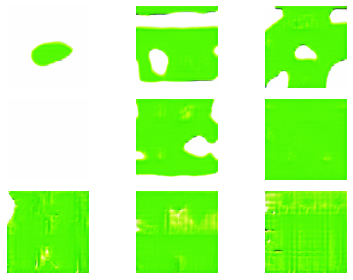

In [65]:
DEMO_NOISE = np.random.normal(0, 1, (9, LATENT_FEATURES_SIZE))

preds = generator.predict(DEMO_NOISE)
preds = (preds + 1) / 2
for i, pred in enumerate(preds):
    plt.subplot(3, 3, i+1)
    plt.imshow(pred)
    plt.axis('off')
plt.tight_layout()
plt.show()

In [46]:
Image.fromarray((preds[1]*255).astype(np.uint8)).save('test1.png')